In [1]:
import joblib
import pandas as pd
import tensorflow as tf

from modeling import *
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings("ignore")
pipeline = joblib.load('../pipelines/feature_engineering_pipeline.joblib')
df = pd.read_csv("../data/orig_train.csv")
df = pipeline.fit_transform(df)
df_val = pd.read_csv("../data/orig_valid.csv")
df_val = pipeline.transform(df_val)

c:\Users\micha\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testing models

In [2]:
y_train = df['FINALIZED_LOAN']
X_train = df.drop(columns="FINALIZED_LOAN")

X_val = df_val.drop(columns="FINALIZED_LOAN")
y_val = df_val['FINALIZED_LOAN']


## Traditional ML

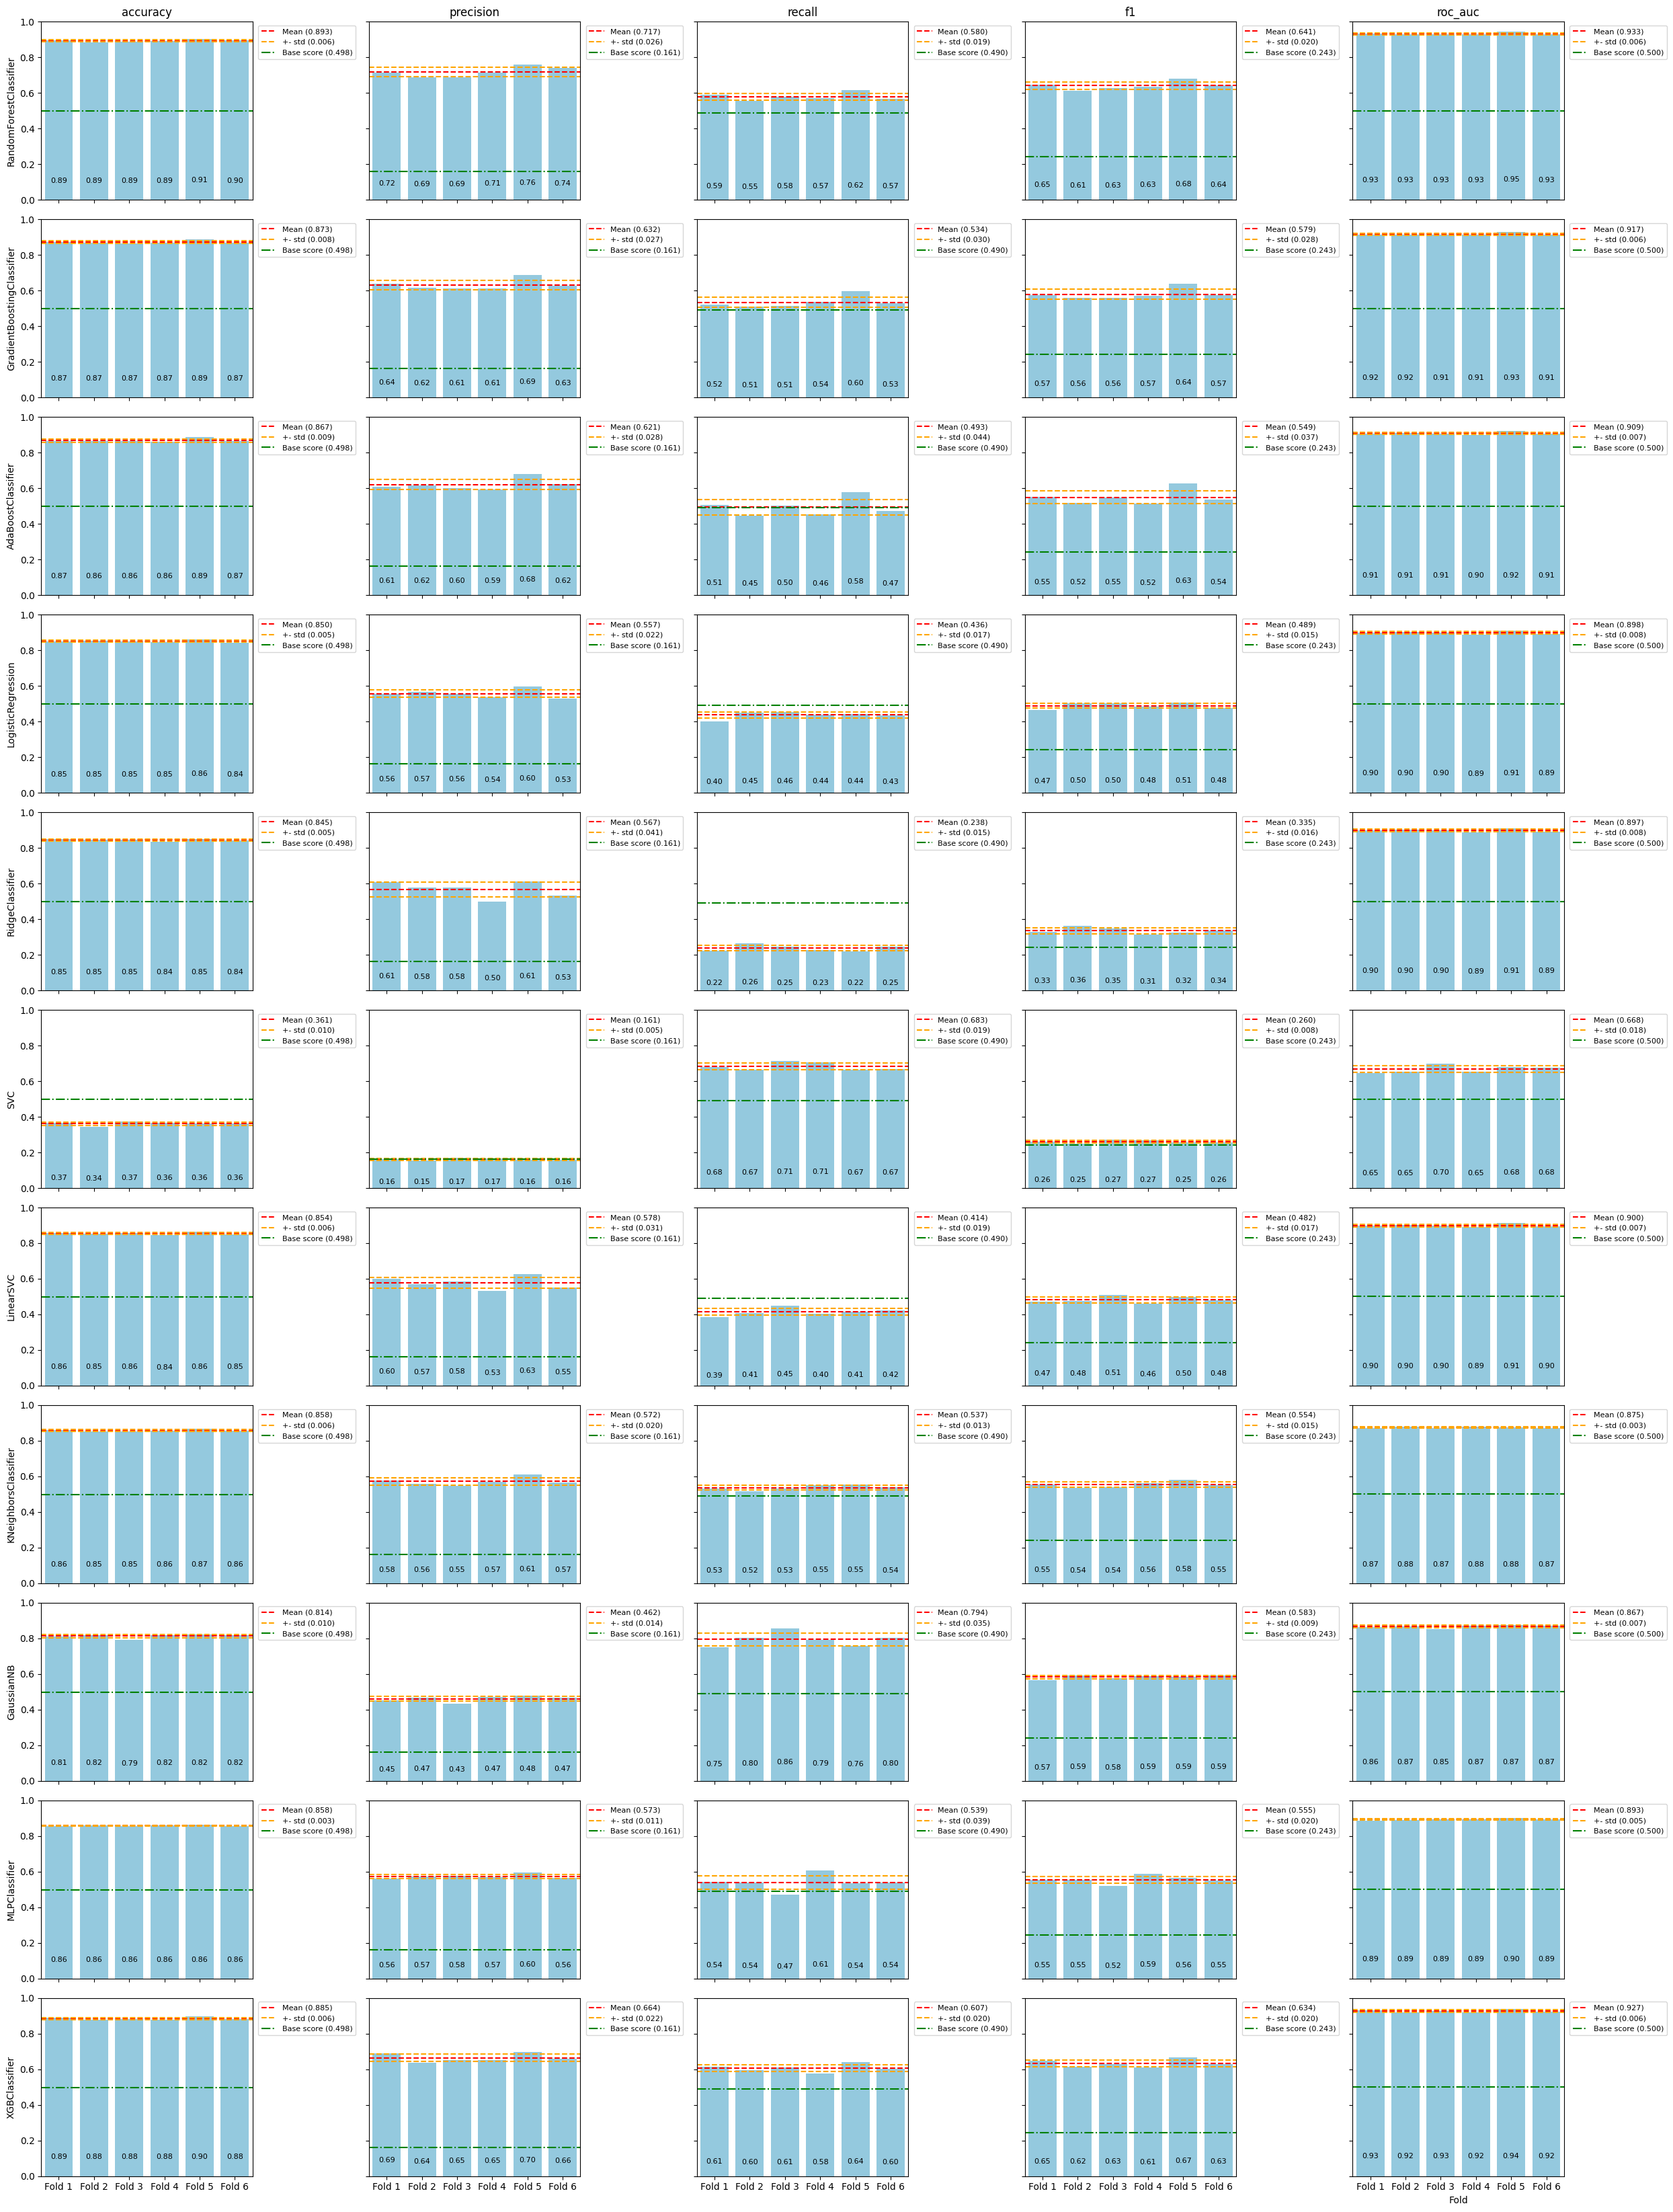

In [3]:
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(algorithm='SAMME'),
    LogisticRegression(max_iter=1000, dual=False),
    RidgeClassifier(),
    SVC(max_iter=1000),
    LinearSVC(dual=False, max_iter=1000),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(max_iter=1000),
    XGBClassifier()
]

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

scores = my_cross_validate(models, X_train, y_train, scoring=scoring)

<Figure size 1200x800 with 0 Axes>

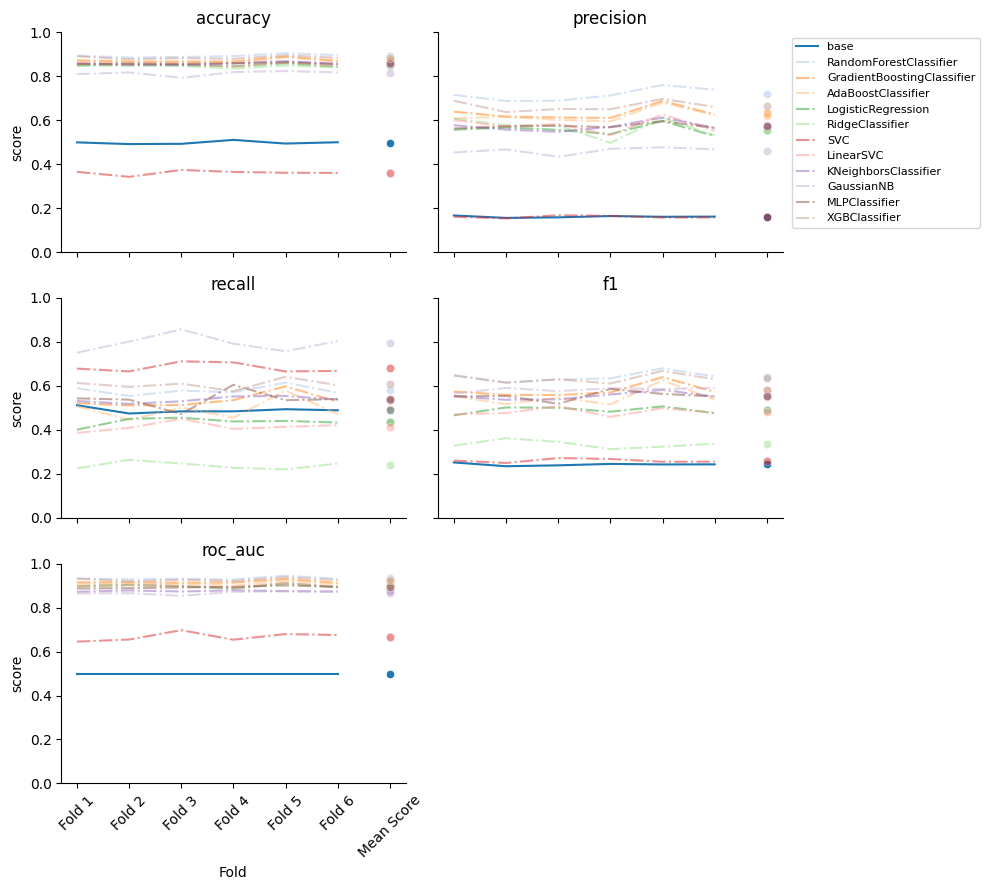

In [4]:
plot_scoring(scoring, scores)

In [5]:
print_scores(scores, "recall")

Models recall
	GaussianNB                    0.7938857111664775
	SVC                           0.6829383599833121
	XGBClassifier                 0.6066934921024825
	RandomForestClassifier        0.5796653058996463
	MLPClassifier                 0.5389251500157911
	KNeighborsClassifier          0.5373158188191348
	GradientBoostingClassifier    0.5344948591079762
	AdaBoostClassifier            0.49333848007392583
	LogisticRegression            0.4364806431866122
	LinearSVC                     0.41429117294997914
	RidgeClassifier               0.23840813652899137


In [6]:
print_scores(scores, "f1")

Models f1
	RandomForestClassifier        0.6411105015194937
	XGBClassifier                 0.6340540027889251
	GaussianNB                    0.5831107786032614
	GradientBoostingClassifier    0.5791979278294889
	MLPClassifier                 0.5546119782847908
	KNeighborsClassifier          0.5539355850935707
	AdaBoostClassifier            0.5492881373776033
	LogisticRegression            0.4891127483409263
	LinearSVC                     0.48191654627497477
	RidgeClassifier               0.3348761905954387
	SVC                           0.25996034517417105


In [7]:
print_scores(scores, "roc_auc")

Models roc_auc
	RandomForestClassifier        0.9328059884873133
	XGBClassifier                 0.9271466976381806
	GradientBoostingClassifier    0.9167595053969609
	AdaBoostClassifier            0.9088979595380599
	LinearSVC                     0.8995225497778612
	LogisticRegression            0.8981464206464741
	RidgeClassifier               0.89739705341036
	MLPClassifier                 0.8927487552212522
	KNeighborsClassifier          0.8749405763990152
	GaussianNB                    0.8670563180878653
	SVC                           0.6676875872468301


Science we predict whether client will be granted with a credit, we're more interested with high recall not high precision - after all, we'd prefer to guess that more people will be granted one than to discourage them from trying to.

Therefore further we'll proceed with GaussianNB (highest recall) and XGB Classifier (it can be greatly fine-tuned) and SVC (second highest recall).

In [8]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'eta': trial.suggest_loguniform('eta', 0.01, 0.5),
            'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
            'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        }
        return after_params_objective(params, X_train, y_train, model_class)
    return objective

study = optimize(X_train, y_train, XGBClassifier, create_objective, 1)

[I 2024-05-07 00:16:47,353] A new study created in memory with name: no-name-779f5417-4b20-4b07-b691-5572b6d230aa
[I 2024-05-07 00:16:50,251] Trial 0 finished with value: 0.8866002952602612 and parameters: {'booster': 'gbtree', 'lambda': 0.92656252222568, 'alpha': 0.0017038104306966292, 'max_depth': 30, 'eta': 0.08502300644344164, 'gamma': 0.23404508186461953, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8866002952602612.


In [9]:
xgb_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, XGBClassifier)

Number of finished trials: 1
Best trial:
  Value: 0.8866002952602612
  Params: 
    booster: gbtree
    lambda: 0.92656252222568
    alpha: 0.0017038104306966292
    max_depth: 30
    eta: 0.08502300644344164
    gamma: 0.23404508186461953
    grow_policy: depthwise
Refitted best model f1-score on valid: 0.889644513137558


In [10]:
preds = xgb_classifier.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)



# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2734
           1       0.65      0.61      0.63       501

    accuracy                           0.89      3235
   macro avg       0.79      0.78      0.78      3235
weighted avg       0.89      0.89      0.89      3235

ROC AUC score: 0.7773925448298721


In [11]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        params = {
            "var_smoothing": trial.suggest_loguniform('var_smoothing', 1e-10, 10.0)
        }
        return after_params_objective(params, X_train, y_train, model_class)
    return objective

study = optimize(X_train, y_train, GaussianNB, create_objective, 1)

[I 2024-05-07 00:16:52,290] A new study created in memory with name: no-name-720a4413-12ee-4b23-953c-b5146ab4f5c1
[I 2024-05-07 00:16:52,499] Trial 0 finished with value: 0.8118828435361912 and parameters: {'var_smoothing': 9.094372879692106e-10}. Best is trial 0 with value: 0.8118828435361912.


In [12]:
gaussian_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, GaussianNB)

Number of finished trials: 1
Best trial:
  Value: 0.8118828435361912
  Params: 
    var_smoothing: 9.094372879692106e-10
Refitted best model f1-score on valid: 0.8238021638330757


In [13]:
def create_objective(X_train, y_train, model_class):
    def objective(trial):
        C = trial.suggest_loguniform('C', 1e-5, 1e5)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        max_iter = trial.suggest_categorical("max_iter", [100])
        probability = trial.suggest_categorical("probability", [True])
        
        if kernel == 'poly':
            degree = trial.suggest_int('degree', 2, 5)
        else:
            degree = 3 
        
        if kernel in ['rbf', 'poly', 'sigmoid']:
            gamma = trial.suggest_loguniform('gamma', 1e-5, 1e5)
        else:
            gamma = 'scale'
        
        params = {
            "C": C,
            "kernel": kernel,
            "degree": degree,
            "gamma": gamma,
            "max_iter": max_iter,
            "probability": probability
        }
        return after_params_objective(params, X_train, y_train, model_class)
    return objective

study = optimize(X_train, y_train, SVC, create_objective, 1)

[I 2024-05-07 00:16:52,565] A new study created in memory with name: no-name-144f0453-7ca4-4e76-88dd-4d8656708ffc
[I 2024-05-07 00:16:53,689] Trial 0 finished with value: 0.2921782573502475 and parameters: {'C': 2.7741255301608874, 'kernel': 'poly', 'max_iter': 100, 'probability': True, 'degree': 2, 'gamma': 8.26861446242506}. Best is trial 0 with value: 0.2921782573502475.


In [14]:
svc_classifier = create_best_estimator(study, X_train, y_train, X_val, y_val, SVC)

Number of finished trials: 1
Best trial:
  Value: 0.2921782573502475
  Params: 
    C: 2.7741255301608874
    kernel: poly
    max_iter: 100
    probability: True
    degree: 2
    gamma: 8.26861446242506
Refitted best model f1-score on valid: 0.2071097372488408


Lets try voting classifier

In [15]:
ensemble_clf = VotingClassifier(estimators=[('XGBClassifier', xgb_classifier), ('GaussianNB', gaussian_classifier), ('SVC', svc_classifier)], voting='soft')

ensemble_clf.fit(X_train, y_train)
y_pred = ensemble_clf.predict(X_val)
score = f1_score(y_val, y_pred, average="micro")

print(f"Refitted best model f1-score on valid: {score}")

Refitted best model f1-score on valid: 0.8819165378670788


In [16]:
preds = y_pred
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)


# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2734
           1       0.63      0.59      0.61       501

    accuracy                           0.88      3235
   macro avg       0.78      0.76      0.77      3235
weighted avg       0.88      0.88      0.88      3235

ROC AUC score: 0.7622239062474903


## Deep Learning

In [17]:
def get_simple_model(dropout=0.2):
    return tf.keras.Sequential(
        [
            layers.Dense(256, input_shape=(X_train.shape[1],)),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(dropout),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(128),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(64),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(dropout),
            layers.Dense(1, activation="sigmoid"),
        ]
    )

In [18]:
import numpy as np

def get_simple_model(dropout=0.2):
    model = tf.keras.Sequential([
        layers.Dense(256, input_shape=(X_train.shape[1],)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(dropout),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(64),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# Compute class weights manually
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# Create the model
simple_model = get_simple_model()
simple_model.summary()
# Compile the model
simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'F1Score'])

# Train the model with class weights
history = simple_model.fit(X_train, y_train, epochs=13, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13
472/472 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8490 - F1Score: 0.2759 - Precision: 0.4156 - Recall: 0.8137 - accuracy: 0.7896 - loss: 0.9728 - val_AUC: 0.8906 - val_F1Score: 0.2682 - val_Precision: 0.4142 - val_Recall: 0.9581 - val_accuracy: 0.7836 - val_loss: 0.3732
Epoch 2/13
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8974 - F1Score: 0.2879 - Precision: 0.4535 - Recall: 0.9464 - accuracy: 0.7993 - loss: 0.7380 - val_AUC: 0.8977 - val_F1Score: 0.2682 - val_Precision: 0.4256 - val_Recall: 0.9421 - val_accuracy: 0.7941 - val_loss: 0.3939
Epoch 3/13
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8988 - F1Score: 0.2829 - Precision: 0.4433 - Recall: 0.9389 - accuracy: 0.7957 - loss: 0.7421 - val_AUC: 0.8998 - val_F1Score: 0.2682 - val_Precision: 0.4223 - val_Recall: 0.9541 - val_accuracy: 0.7907 - val_loss: 0.3694
Epoch 4/13
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9004 - F1Score: 0.2874 - Precision: 0.4494 - Recall: 0.9464 - accuracy: 0.7966 - loss: 0.7409

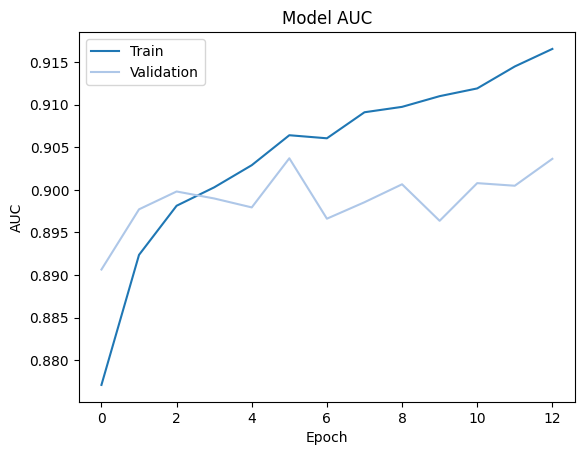

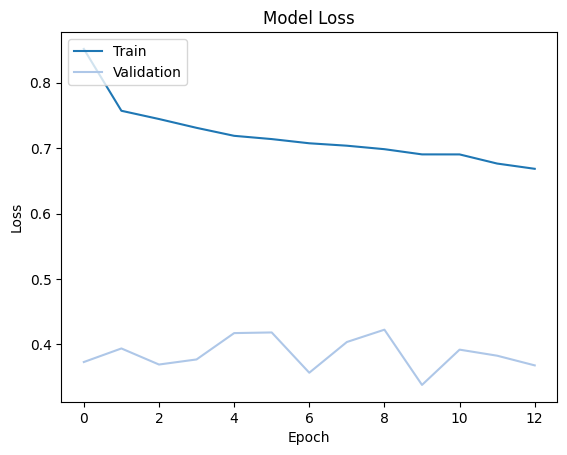

In [19]:
# Plot accuracy
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
preds = simple_model.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)


# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      2734
           1       0.46      0.93      0.61       501

    accuracy                           0.82      3235
   macro avg       0.72      0.86      0.75      3235
weighted avg       0.90      0.82      0.84      3235

ROC AUC score: 0.904086486865333


In [21]:
simple_classifier_02 = get_simple_model()
simple_classifier_02.summary()
history = train_model(simple_classifier_02, X_train, y_train, X_val, y_val)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.2733 - loss: 0.3309 - val_f1_score: 0.2682 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2789 - loss: 0.2760 - val_f1_score: 0.2682 - val_loss: 0.2756 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2798 - loss: 0.2767 - val_f1_score: 0.2682 - val_loss: 0.2706 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2822 - loss: 0.2716 - val_f1_score: 0.2682 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2778 - loss: 0.2640 - val_f1_score: 0.2682 - val_loss: 0.2666 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2845 - loss: 0.2587 - val_f1_score: 0.2682 - val_loss: 0.2664 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2853 - loss: 0.

In [22]:
preds = simple_classifier_02.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)


# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2734
           1       0.57      0.50      0.53       501

    accuracy                           0.86      3235
   macro avg       0.74      0.71      0.72      3235
weighted avg       0.86      0.86      0.86      3235

ROC AUC score: 0.9080383490517137


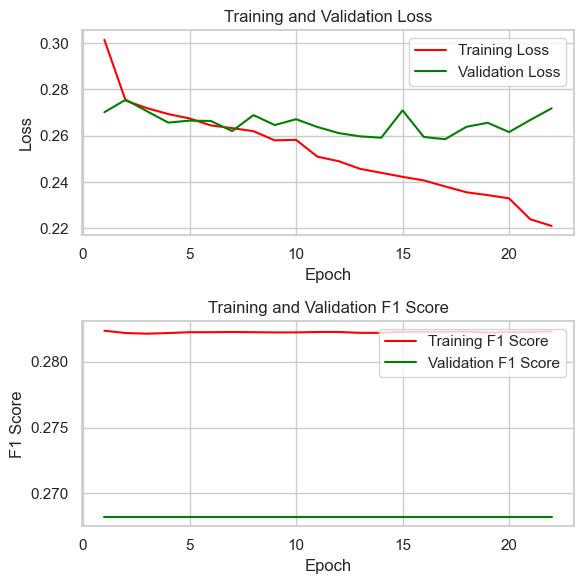

In [23]:
plot_history(history)

In [24]:
simple_classifier_00 = get_simple_model()
simple_classifier_00.summary()
history = train_model(simple_classifier_00, X_train, y_train, X_val, y_val)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.2843 - loss: 0.3510 - val_f1_score: 0.2682 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2854 - loss: 0.2791 - val_f1_score: 0.2682 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2851 - loss: 0.2777 - val_f1_score: 0.2682 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2849 - loss: 0.2755 - val_f1_score: 0.2682 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2759 - loss: 0.2673 - val_f1_score: 0.2682 - val_loss: 0.2650 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2818 - loss: 0.2610 - val_f1_score: 0.2682 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2831 - loss: 0.

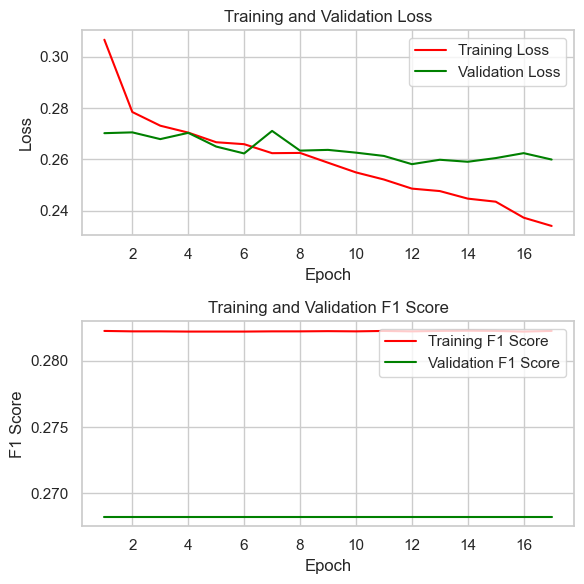

In [25]:
plot_history(history)

In [26]:
import numpy as np

def residual_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    residual = x
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Add()([x, residual])
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' activation for binary classification
    model = tf.keras.Model(inputs, outputs)
    return model

# Compute class weights manually
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# Create and compile the model
residual_net_classifier = residual_net()
residual_net_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'F1Score'])

# Train the model with class weights
history = residual_net_classifier.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)


Epoch 1/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7958 - F1Score: 0.2864 - Precision: 0.3457 - Recall: 0.7930 - accuracy: 0.7098 - loss: 1.2253 - val_AUC: 0.8856 - val_F1Score: 0.2682 - val_Precision: 0.4279 - val_Recall: 0.9481 - val_accuracy: 0.7957 - val_loss: 0.4046
Epoch 2/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8729 - F1Score: 0.2840 - Precision: 0.4321 - Recall: 0.8872 - accuracy: 0.7883 - loss: 0.8530 - val_AUC: 0.8904 - val_F1Score: 0.2682 - val_Precision: 0.4195 - val_Recall: 0.9461 - val_accuracy: 0.7889 - val_loss: 0.4079
Epoch 3/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - F1Score: 0.2776 - Precision: 0.4365 - Recall: 0.9077 - accuracy: 0.7964 - loss: 0.7940 - val_AUC: 0.8945 - val_F1Score: 0.2682 - val_Precision: 0.4186 - val_Recall: 0.9441 - val_accuracy: 0.7883 - val_loss: 0.3929
Epoch 4/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - F1Score: 0.2762 - Precision: 0.4382 - Recall: 0.9193 - accuracy: 0.7982 - loss: 0.7528

In [27]:
def residual_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    residual = x
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Add()([x, residual])
    outputs = layers.Dense(1, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [28]:
residual_net_classifier = get_simple_model()
residual_net_classifier.summary()
history = train_model(residual_net_classifier, X_train, y_train, X_val, y_val)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,809 (280.50 KB)

 Trainable params: 71,809 (280.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.2800 - loss: 0.3505 - val_f1_score: 0.2682 - val_loss: 0.2698 - learning_rate: 0.0010
Epoch 2/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2781 - loss: 0.2754 - val_f1_score: 0.2682 - val_loss: 0.2655 - learning_rate: 0.0010
Epoch 3/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2836 - loss: 0.2723 - val_f1_score: 0.2682 - val_loss: 0.2646 - learning_rate: 0.0010
Epoch 4/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2836 - loss: 0.2715 - val_f1_score: 0.2682 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 5/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2855 - loss: 0.2731 - val_f1_score: 0.2682 - val_loss: 0.2637 - learning_rate: 0.0010
Epoch 6/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2807 - loss: 0.2632 - val_f1_score: 0.2682 - val_loss: 0.2607 - learning_rate: 0.0010
Epoch 7/100
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.2816 - loss: 0.

In [29]:
import numpy as np

class DropConnect(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(DropConnect, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

def drop_connect_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = DropConnect(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = DropConnect(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = DropConnect(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' activation for binary classification
    model = tf.keras.Model(inputs, outputs)
    return model

# Compute class weights manually
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# Create and compile the model
drop_connect_net_classifier = drop_connect_net()
drop_connect_net_classifier.summary()
drop_connect_net_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'F1Score'])

# Train the model with class weights
history = drop_connect_net_classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect (DropConnect)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect_1 (DropConnect)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_connect_2 (DropConnect)    │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,409 (68.00 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8002 - F1Score: 0.2805 - Precision: 0.3568 - Recall: 0.7704 - accuracy: 0.7300 - loss: 1.1444 - val_AUC: 0.8905 - val_F1Score: 0.2682 - val_Precision: 0.4147 - val_Recall: 0.9561 - val_accuracy: 0.7842 - val_loss: 0.4044
Epoch 2/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8844 - F1Score: 0.2853 - Precision: 0.4415 - Recall: 0.9276 - accuracy: 0.7927 - loss: 0.8010 - val_AUC: 0.8945 - val_F1Score: 0.2682 - val_Precision: 0.4186 - val_Recall: 0.9501 - val_accuracy: 0.7879 - val_loss: 0.3837
Epoch 3/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8879 - F1Score: 0.2842 - Precision: 0.4454 - Recall: 0.9437 - accuracy: 0.7960 - loss: 0.7748 - val_AUC: 0.8964 - val_F1Score: 0.2682 - val_Precision: 0.4308 - val_Recall: 0.9441 - val_accuracy: 0.7981 - val_loss: 0.3531
Epoch 4/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8953 - F1Score: 0.2770 - Precision: 0.4309 - Recall: 0.9351 - accuracy: 0.7913 - loss: 0.7416

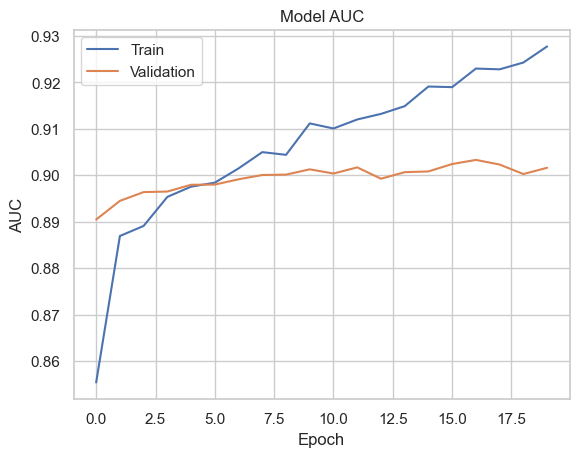

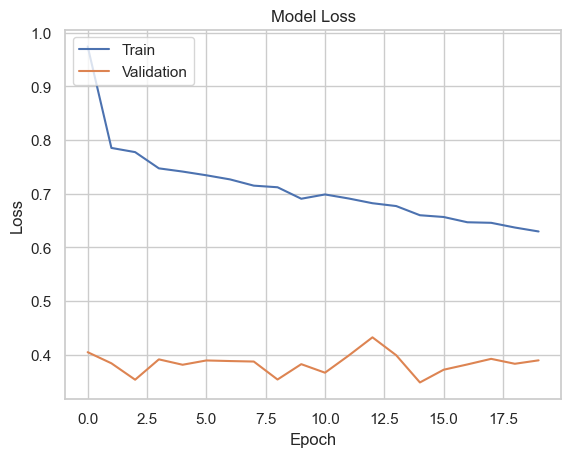

In [30]:
# Plot accuracy
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
preds = drop_connect_net_classifier.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)


# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      2734
           1       0.44      0.91      0.59       501

    accuracy                           0.80      3235
   macro avg       0.71      0.85      0.73      3235
weighted avg       0.90      0.80      0.83      3235

ROC AUC score: 0.9012435991221653


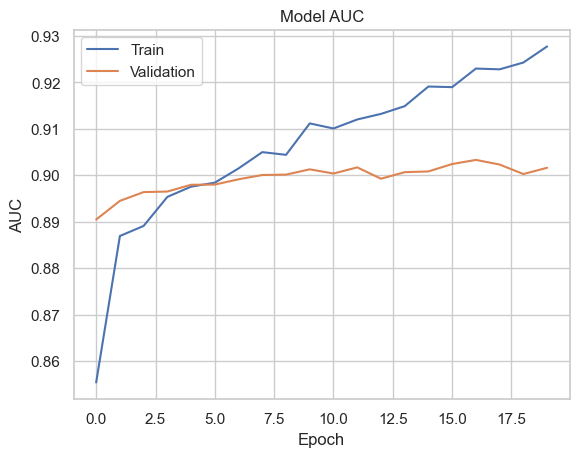

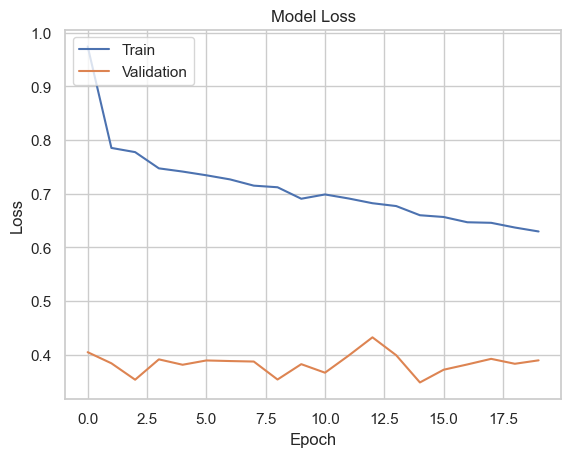

In [32]:
# Plot accuracy
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
import numpy as np

# Compute class weights manually
total_samples = len(y_train)
class_counts = np.bincount(y_train)
class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# Rest of the code remains the same
def dense_net():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

dense_net_classifier = dense_net()
dense_net_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy', 'Precision', 'Recall', 'F1Score'])

# Train the model with class weights
history = dense_net_classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)


Epoch 1/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8038 - F1Score: 0.2829 - Precision: 0.3332 - Recall: 0.8215 - accuracy: 0.6959 - loss: 1.1173 - val_AUC: 0.8841 - val_F1Score: 0.2682 - val_Precision: 0.4252 - val_Recall: 0.9361 - val_accuracy: 0.7941 - val_loss: 0.4139
Epoch 2/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8791 - F1Score: 0.2857 - Precision: 0.4287 - Recall: 0.9155 - accuracy: 0.7826 - loss: 0.8264 - val_AUC: 0.8944 - val_F1Score: 0.2682 - val_Precision: 0.4277 - val_Recall: 0.9441 - val_accuracy: 0.7957 - val_loss: 0.3767
Epoch 3/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8862 - F1Score: 0.2768 - Precision: 0.4329 - Recall: 0.9151 - accuracy: 0.7938 - loss: 0.7705 - val_AUC: 0.8958 - val_F1Score: 0.2682 - val_Precision: 0.4099 - val_Recall: 0.9581 - val_accuracy: 0.7799 - val_loss: 0.4140
Epoch 4/20
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8910 - F1Score: 0.2810 - Precision: 0.4371 - Recall: 0.9371 - accuracy: 0.7925 - loss: 0.7595

In [34]:

# Make predictions
preds = dense_net_classifier.predict(X_val)
threshold = 0.5
preds_binary = np.where(preds > threshold, 1, 0)

# Print classification report and ROC AUC score
print(classification_report(y_val, preds_binary))
print(f"ROC AUC score: {roc_auc_score(y_val, preds)}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      2734
           1       0.43      0.96      0.59       501

    accuracy                           0.80      3235
   macro avg       0.71      0.86      0.73      3235
weighted avg       0.90      0.80      0.82      3235

ROC AUC score: 0.9034717689712017


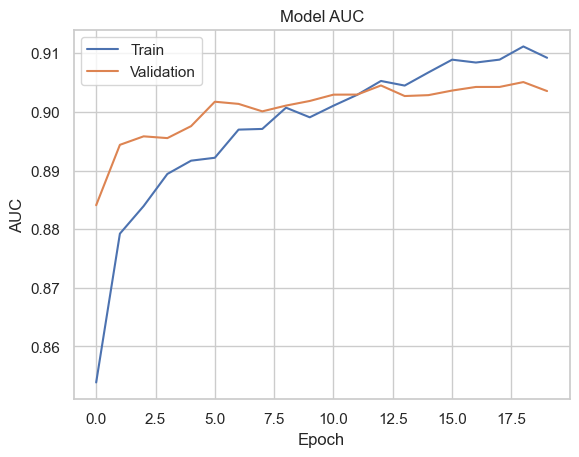

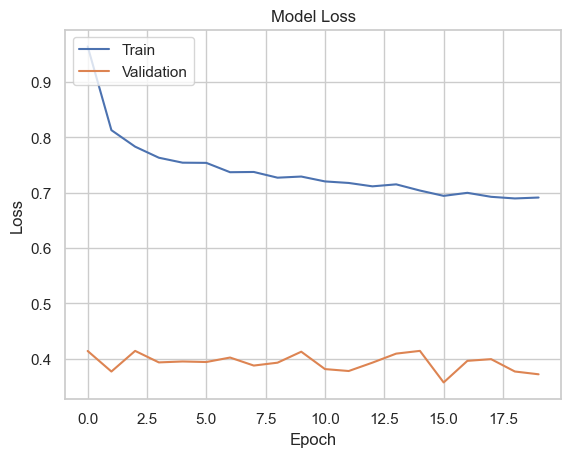

In [35]:
# Plot accuracy
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model Eplanation

In [36]:
import shap
import xgboost

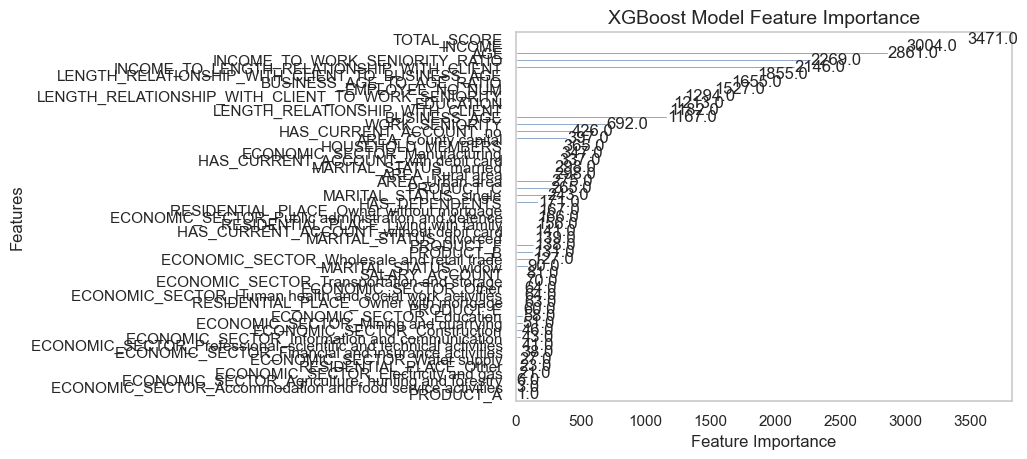

In [37]:

xgboost.plot_importance(xgb_classifier, xlabel='Feature Importance', title='XGBoost Model Feature Importance', grid=False)

# Adjust plot parameters
plt.rcParams['figure.figsize'] = [10, 7]  # Set figure size
plt.rcParams['font.size'] = 12  # Set font size
plt.title("XGBoost Model Feature Importance", fontsize=14)  # Add title

# Show the plot
plt.show()

In [38]:
xgb_model = xgboost.XGBClassifier()
xgb_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

In [39]:
shap.initjs()

In [40]:
shap.force_plot(explainer.expected_value, shap_values[2, :], X_train.iloc[0, :])

In [41]:
shap.force_plot(explainer.expected_value, shap_values[110, :], X_train.iloc[0, :])

In [42]:
shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], X_train.iloc[:1000, :]
)

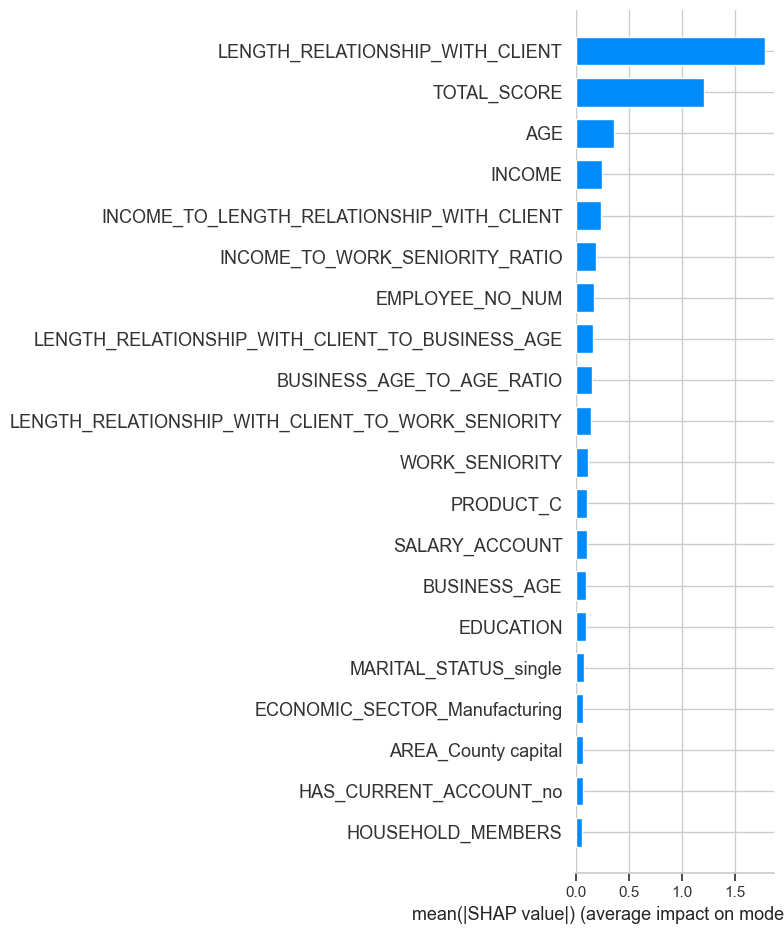

In [43]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

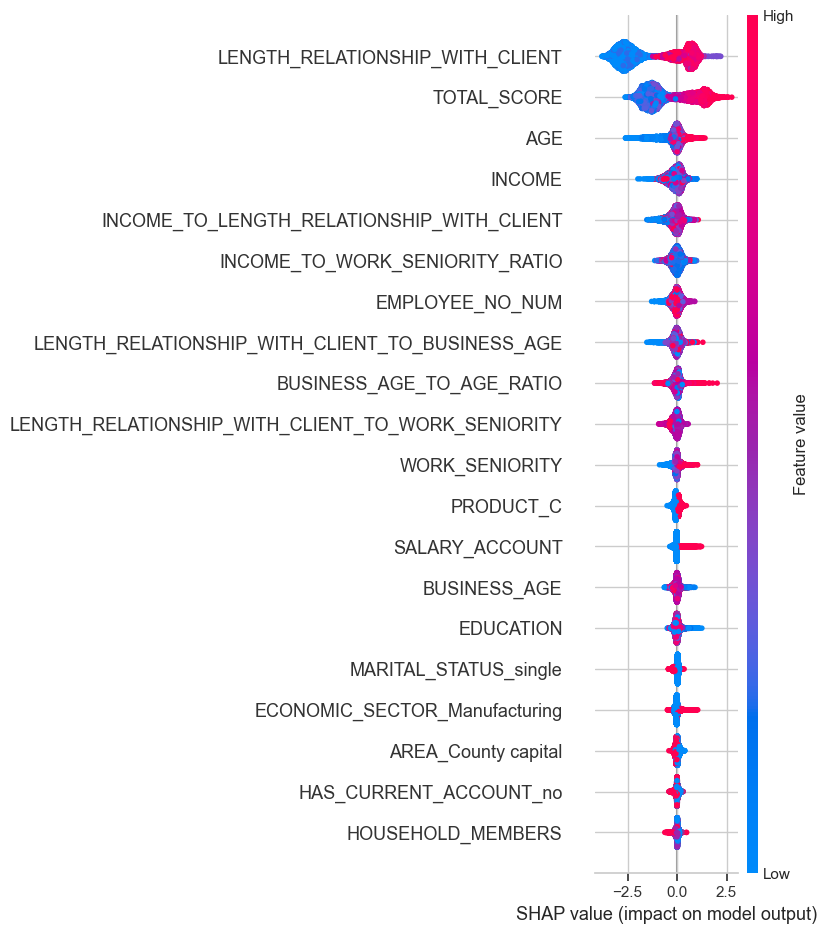

In [44]:
shap.summary_plot(shap_values, X_train)

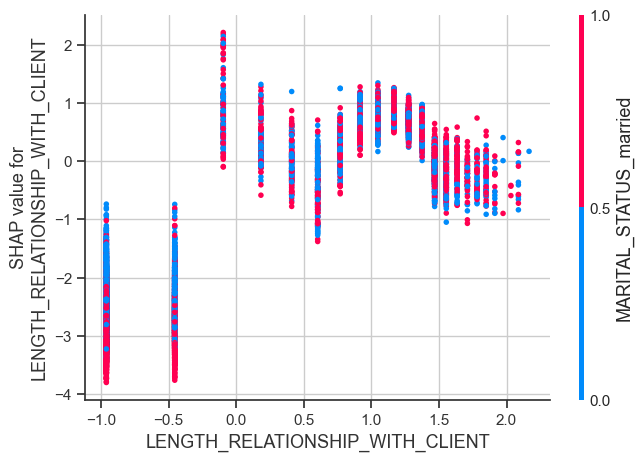

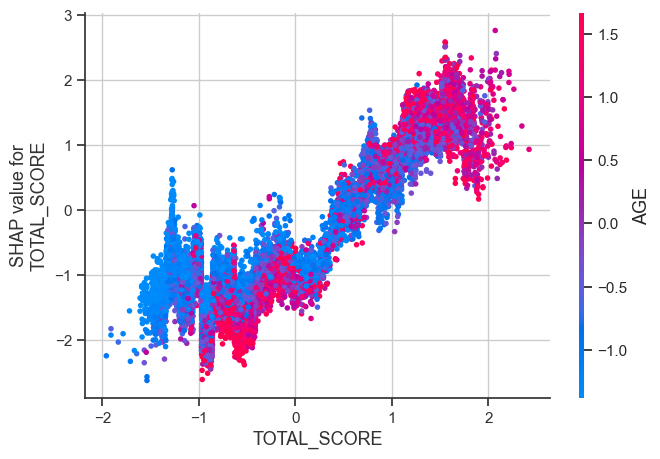

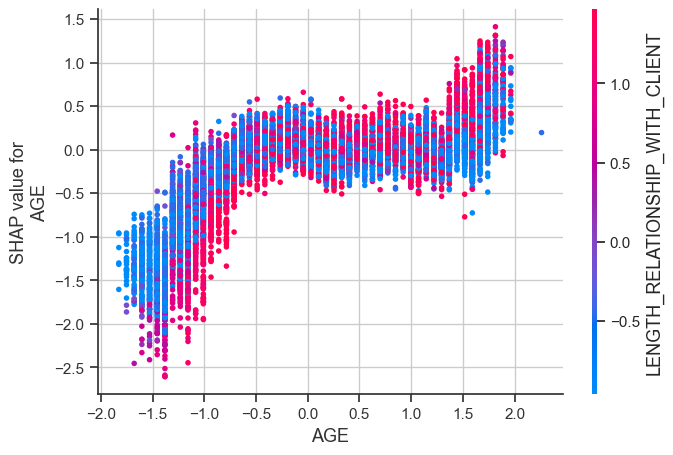

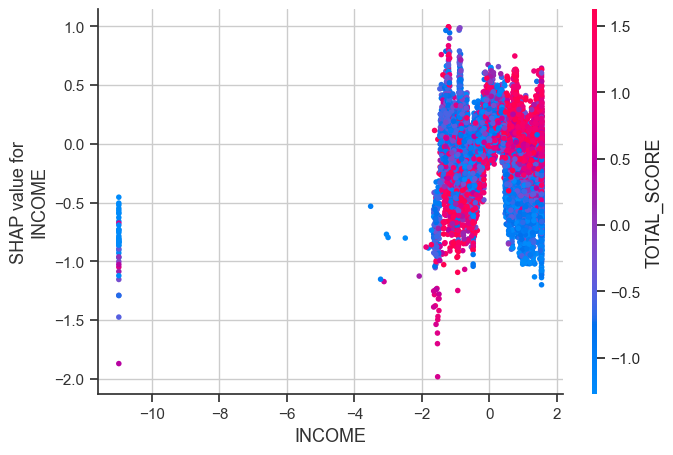

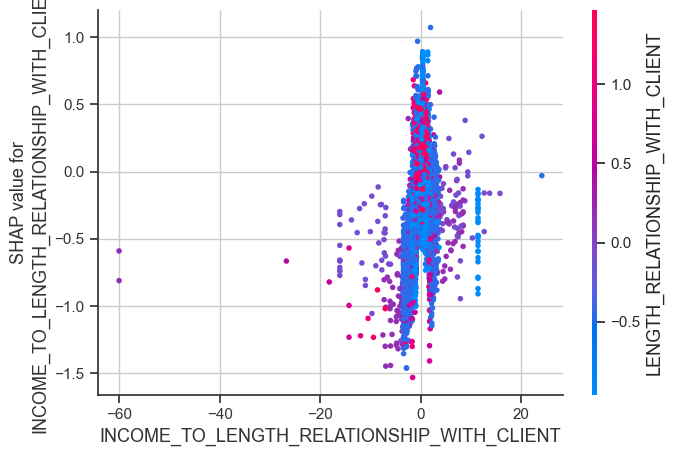

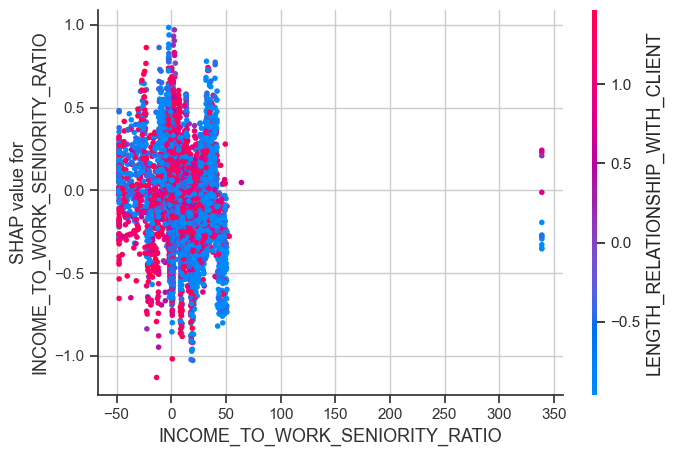

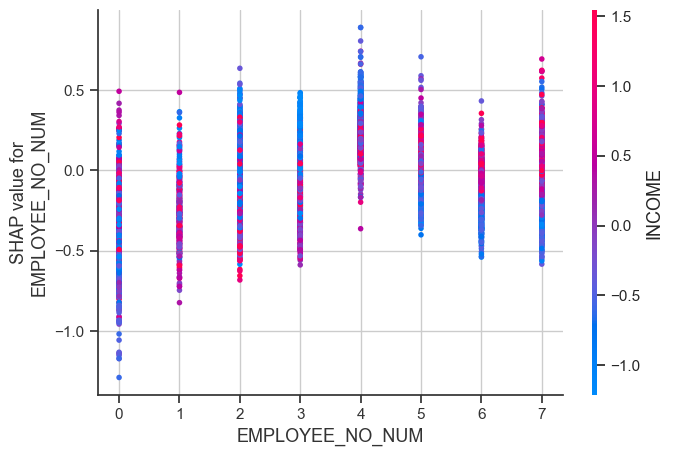

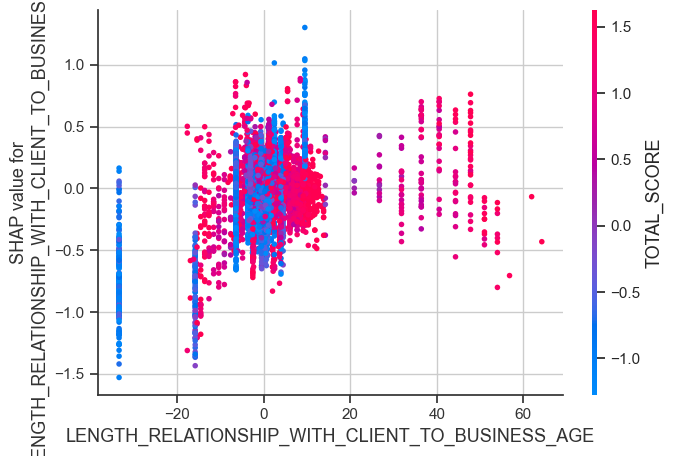

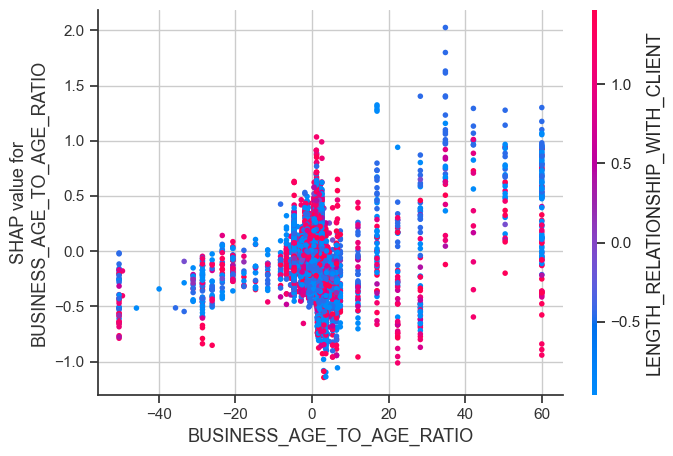

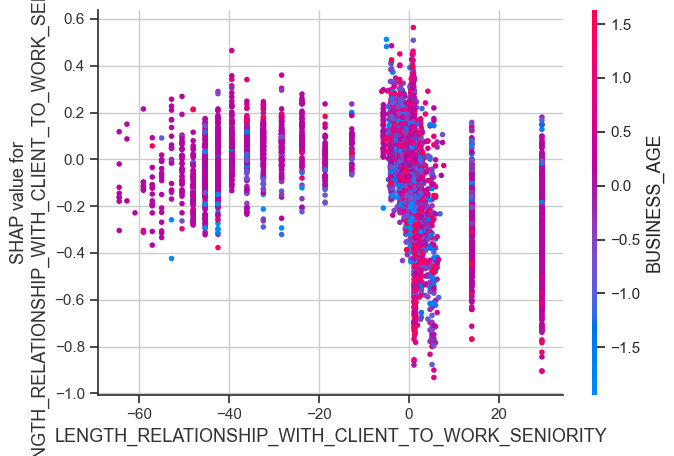

In [45]:
import numpy as np

# Calculate absolute SHAP values for each feature
abs_shap_values = np.abs(shap_values).mean(axis=0)

# Sort features based on their mean absolute SHAP values
sorted_indices = np.argsort(abs_shap_values)[::-1]

# Select the top 10 features
top_10_features = X_train.columns[sorted_indices][:10]

# Plot dependence plots for the top 10 features
for name in top_10_features:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)


# Final model

Based on above research we'll go into production with our voting classifier. We believe it'll have best generalization capabilities and it will focus more on recall to precision.

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

class FinalModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pipeline = pipeline
        self.model = ensemble_clf
    
    def predict(self, X):
        if "FINALIZED_LOAN" not in X.columns:
            X["FINALIZED_LOAN"] = np.ones(X.shape[0])
        
        X = pipeline.transform(X)
        X.drop(columns=["FINALIZED_LOAN"], inplace=True)
        return ensemble_clf.predict(X.values)    

    def set_output(self, *args, **kwargs):
        return self


In [47]:
df_val = pd.read_csv("../data/orig_valid.csv")
y_val = df_val["FINALIZED_LOAN"]
df_val.drop(columns=["FINALIZED_LOAN"], inplace=True)

final_model = FinalModel()
y_pred = final_model.predict(df_val)

In [48]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2734
           1       0.62      0.59      0.60       501

    accuracy                           0.88      3235
   macro avg       0.77      0.76      0.77      3235
weighted avg       0.88      0.88      0.88      3235



In [49]:
joblib.dump(
    final_model, "../pipelines/final_model.joblib"
)

['../pipelines/final_model.joblib']